In [1]:
import pm4py
import pm4pyExtension
dataPath = "/media/sasha/HDD-bigboy/Data/DOI-10-13012-b2idb-0647142_v3/PhoenixBLN-NYT_1980-2018.csv"

In [2]:
unprocessed_event_log = pm4pyExtension.preprocessing.Pheonix.import_csv(dataPath)
#in Pheonix preprosses we set case_id='conflict_id'
event_log = pm4pyExtension.preprocessing.Pheonix.preprocess(unprocessed_event_log) #preprocesses the event log to a pm4py event log, replace action codes with text
#setting key gets you a spesific trace with case_id = key, for modeling spesific interactions
interaction_event_log_USA_DEU = pm4pyExtension.preprocessing.Pheonix.preprocess(unprocessed_event_log, key="USADEU") #key is conflict id so all entrys with key USADEU are actions form US to DE
interaction_event_log_DEU_USA = pm4pyExtension.preprocessing.Pheonix.preprocess(unprocessed_event_log, key="DEUUSA")
interaction_event_log_DEU_GBR = pm4pyExtension.preprocessing.Pheonix.preprocess(unprocessed_event_log, key="DEUGBR")
interaction_event_log_GBR_USA = pm4pyExtension.preprocessing.Pheonix.preprocess(unprocessed_event_log, key="GBRUSA")

/home/sasha/.local/lib/python3.10/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/home/sasha/.local/lib/python3.10/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/home/sasha/.local/lib/python3.10/site-packages/pm4py/objects/log/util/dataframe_utils.py:180: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[col] = pd.to_datetime(df[col], utc=True)
/home/sasha/.local/lib/py

dict_keys(['Consult', 'Express intent to cooperate', 'Make Public Statement', 'Engage in material cooperation', 'Engage in diplomatic cooperation', 'Coerce', 'Fight', 'Disapprove', 'Appeal', 'Yield', 'Provide aid', 'Reduce relations', 'Demand', 'Threaten', 'Reject', 'Assault', 'Investigate', 'Protest', 'Exhibit force posture', 'Use unconventional mass violence'])


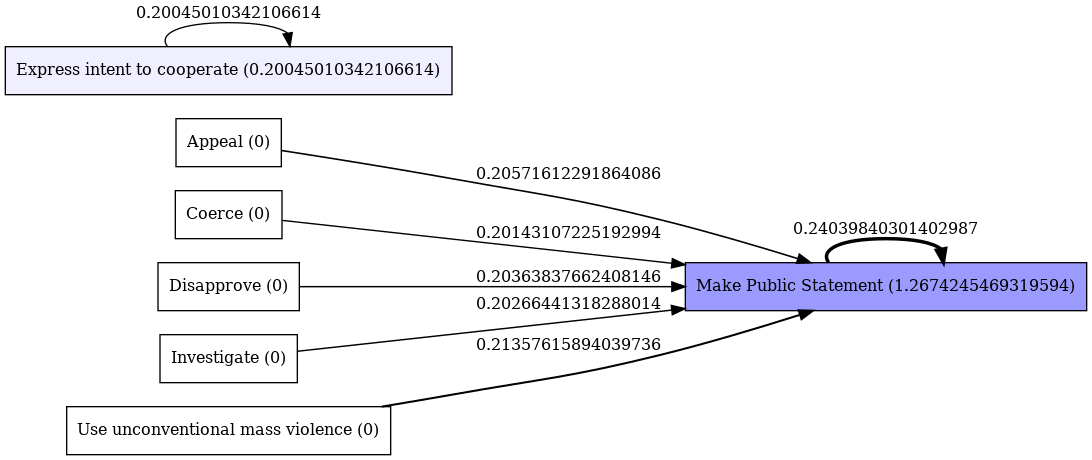

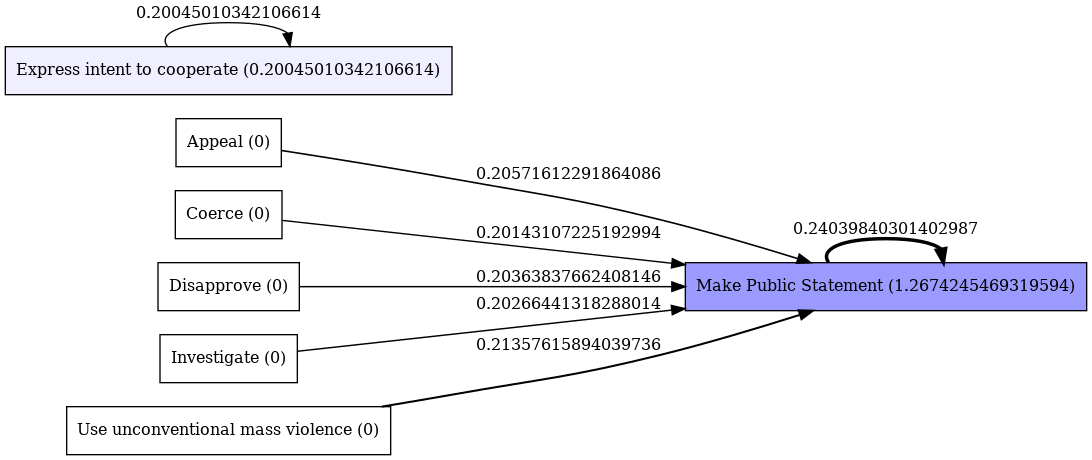

In [3]:
#example dfg call
dfg = pm4pyExtension.tools.make_dfg(event_log,
            max_path_denoise=False, minThresh=0.2, show=True, 
            normalize=True, normalize_to="source")

#example manual dfg construction
dfg, start_activities, end_activities = pm4py.discover_dfg(event_log) #for efg; efg = get_eventually_follows_in_days_graph(event_log, daysFollow)
dfg = pm4pyExtension.tools.normalize_dfg_to(dfg, normalize_to="source")
dfg = pm4pyExtension.algo.reduction.minthreshold_dfg(dfg, 0.2)

pm4py.view_dfg(dfg, start_activities=None, end_activities=None, format='png')

#note this creates a dfg of all interactions in the database

dict_keys(['Disapprove'])


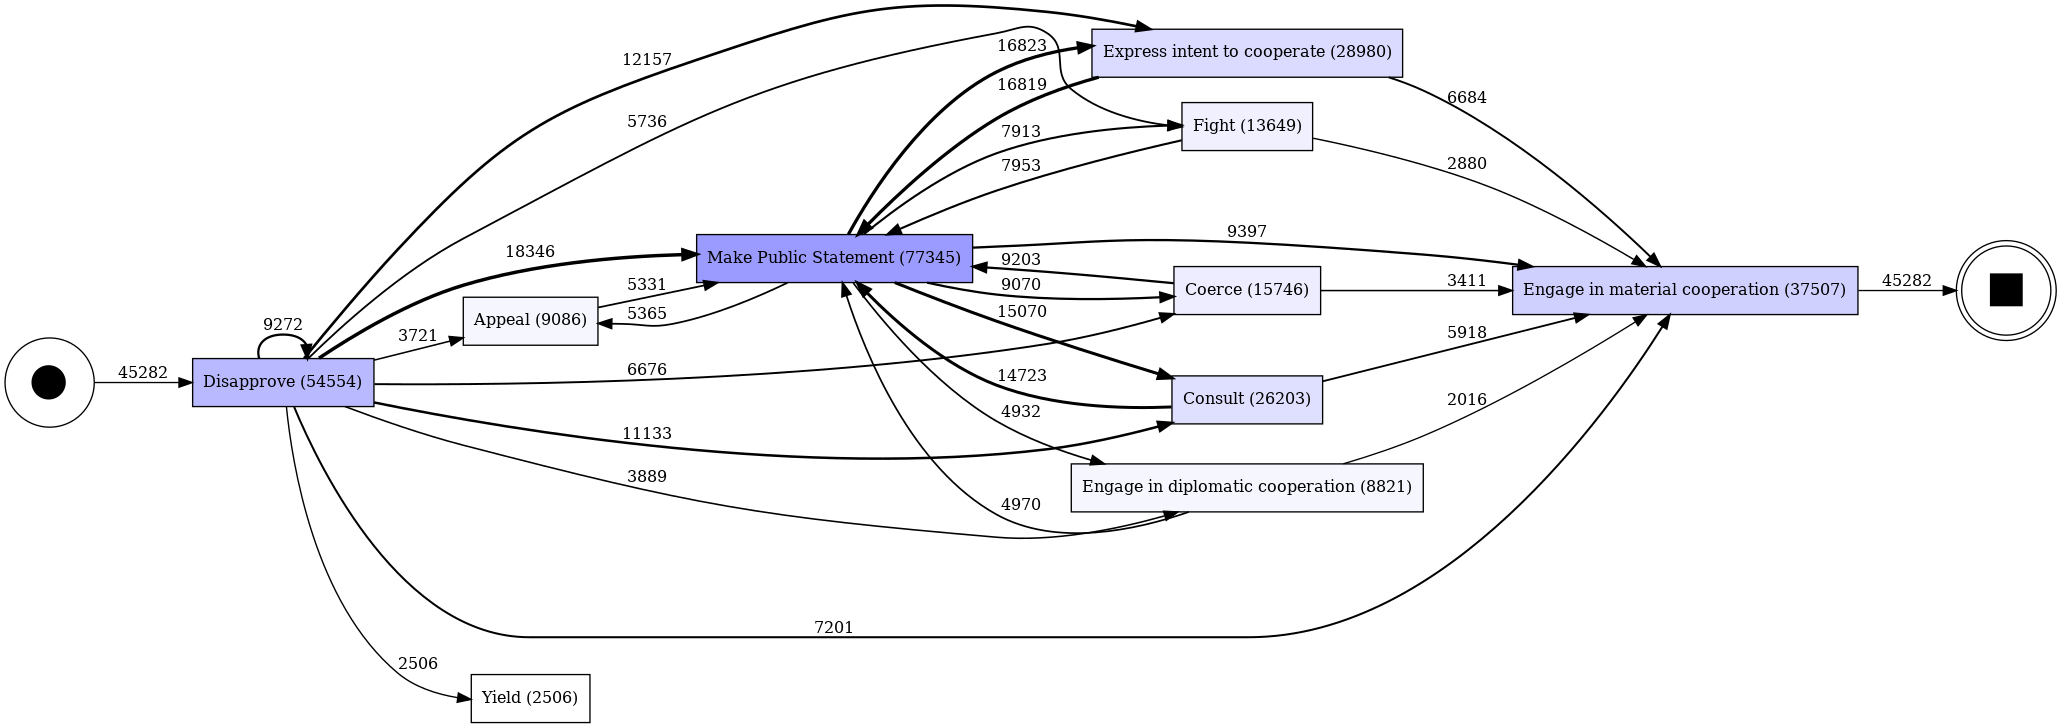

In [4]:
#look at path between two actions
case_split_log = pm4py.filter_between(event_log, "Disapprove", "Engage in material cooperation")
#usual normalization dosnt work well wenn all traces start and end in the same place, instead we use max_path_denoise
#this keeps only the largest in and out for each node, so we retain information about the most common paths
dfg = pm4pyExtension.tools.make_dfg(case_split_log, show=True, minThresh=4000,show_start_end=True, max_path_denoise=True)

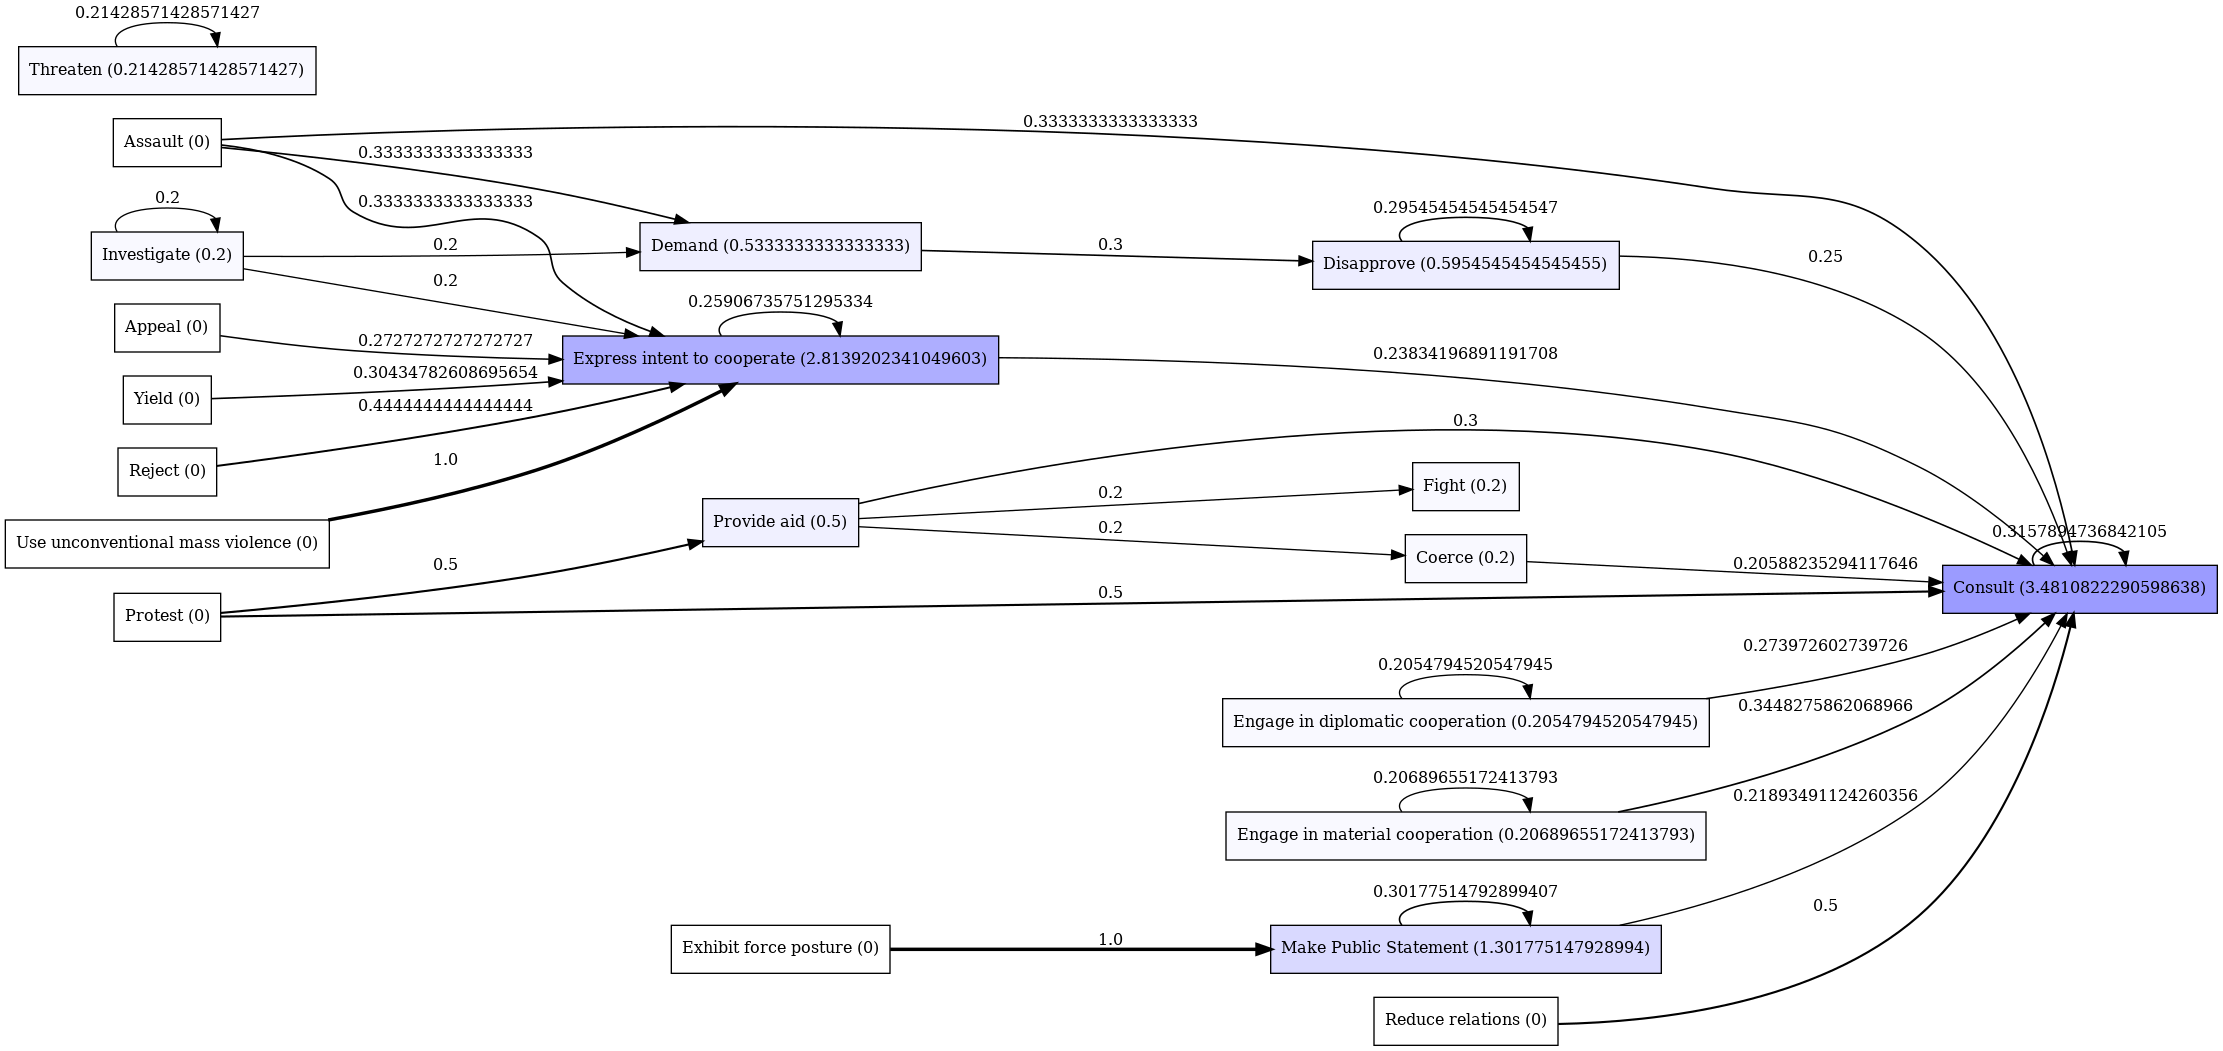

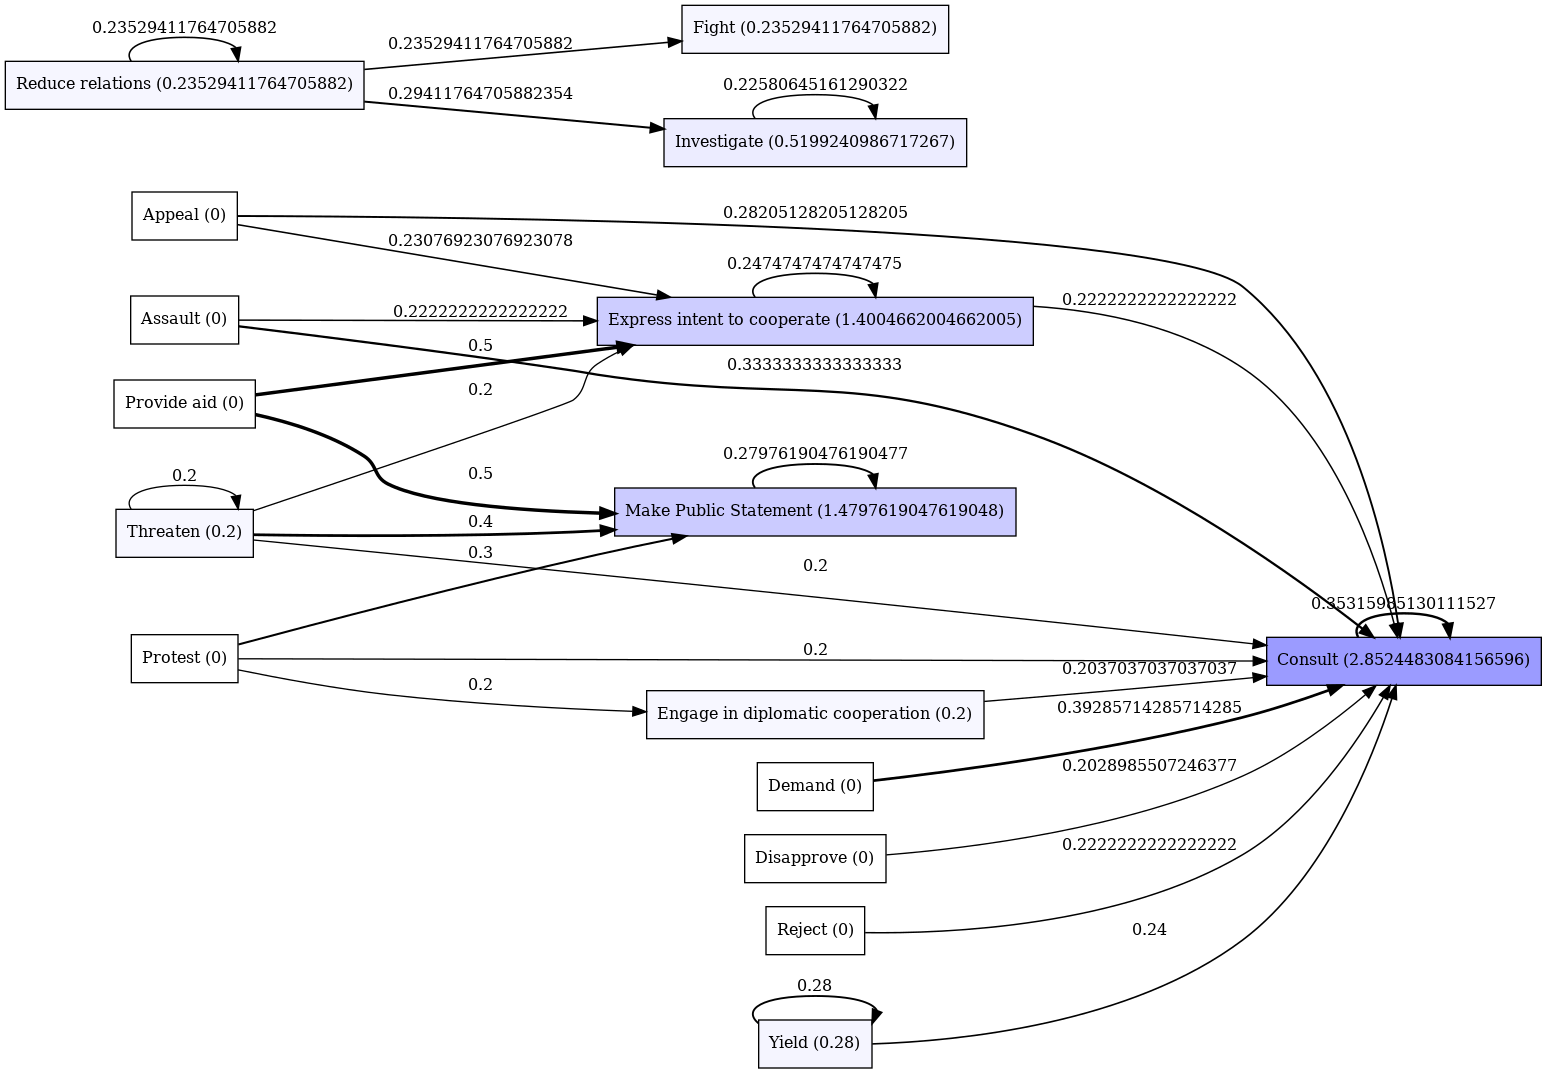

In [5]:
#example efig call
efg_USA_DEU = pm4pyExtension.tools.make_efig(interaction_event_log_USA_DEU,
            max_path_denoise=False, minThresh=0.2, show=True, 
            normalize=True, normalize_to="source", daysFollow=3)

#example manual efig construction
efg_DEU_USA = pm4pyExtension.algo.discovery.get_eventually_follows_in_days_graph(interaction_event_log_DEU_USA, daysFollow=3)
efg_DEU_USA = pm4pyExtension.tools.normalize_dfg_to(efg_DEU_USA, normalize_to="source")
efg_DEU_USA = pm4pyExtension.algo.reduction.minthreshold_dfg(efg_DEU_USA, 0.2)
pm4py.view_dfg(efg_DEU_USA, start_activities=None, end_activities=None, format='png')

#efig is a modifyed efg that only connects eventualy following actions if they are withing the daysFollow time frame

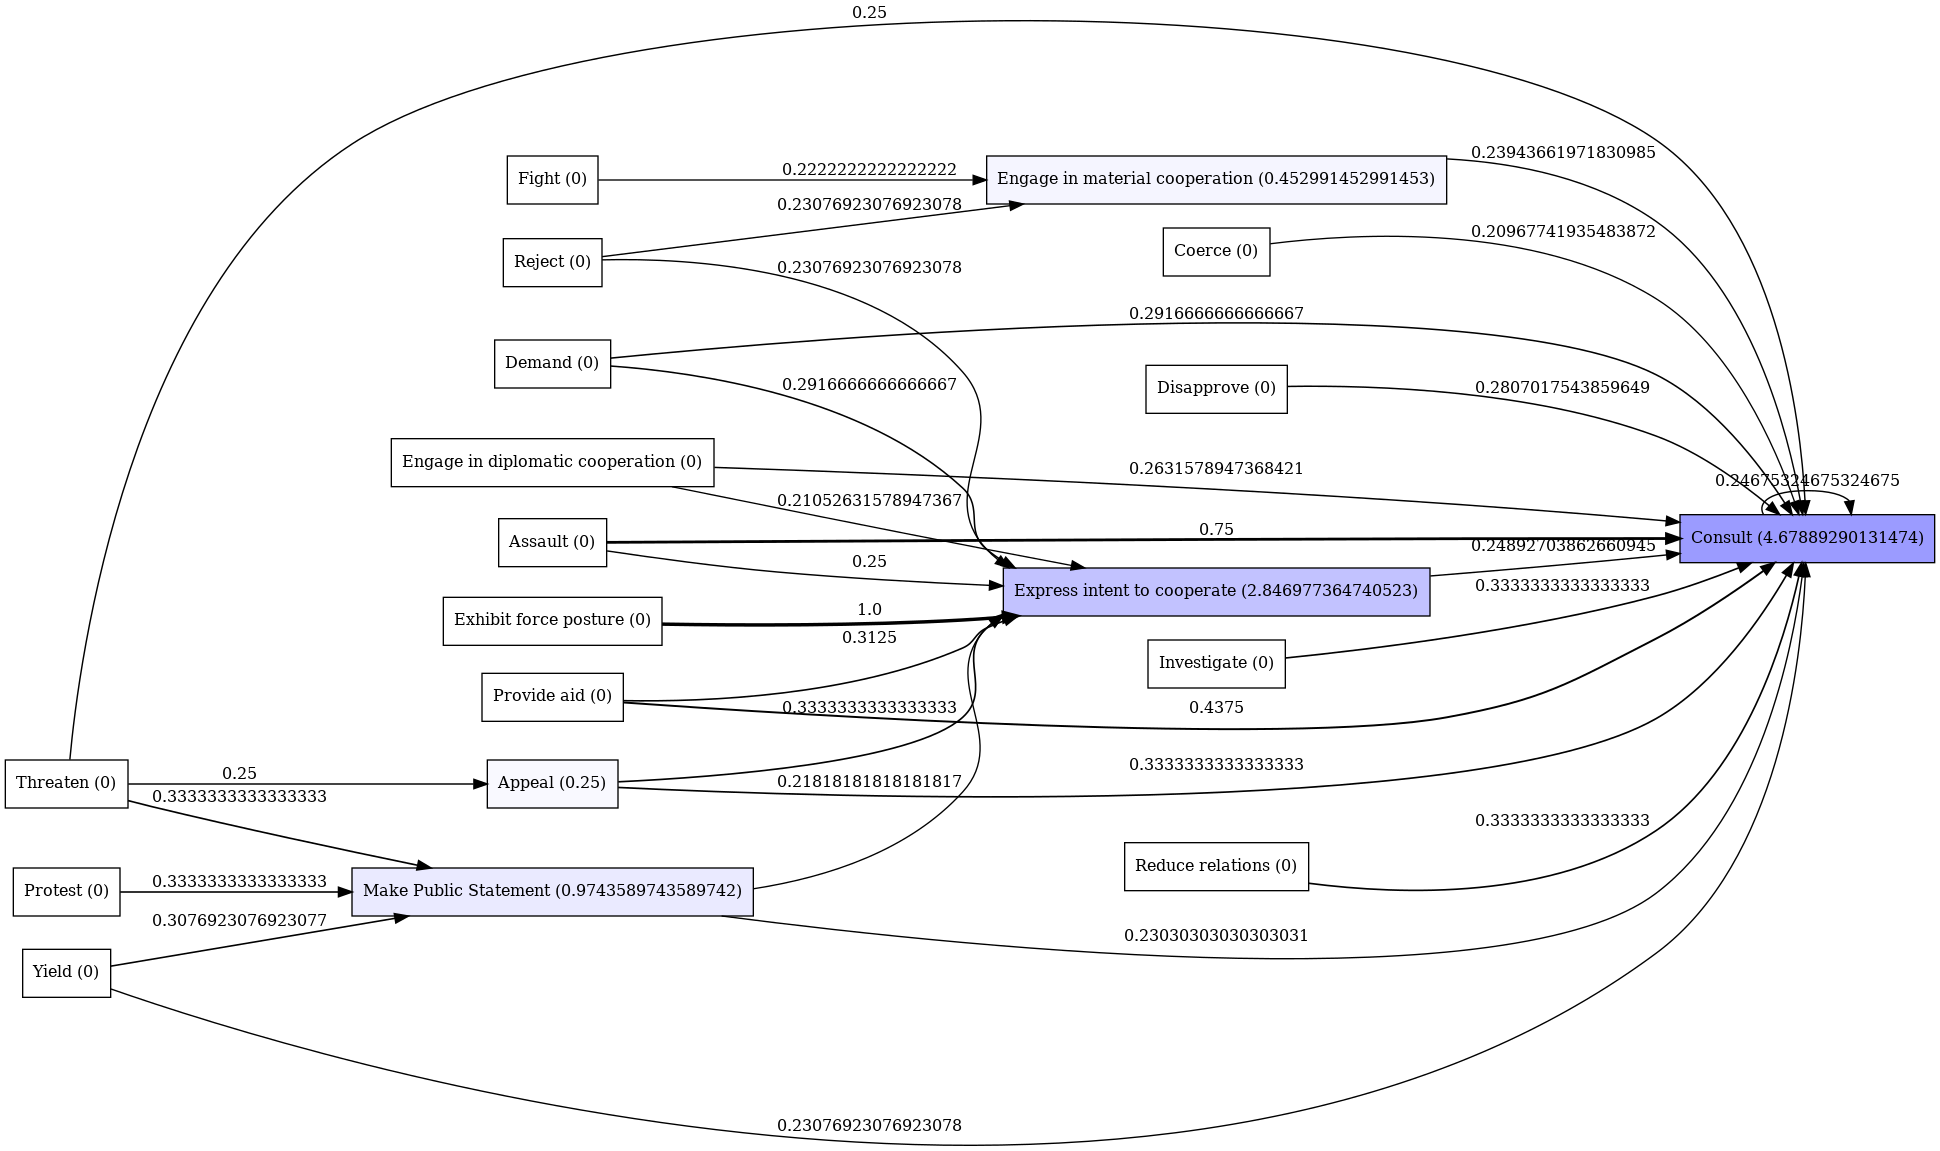

In [6]:
#example action reprectin graph creation
#note the way to read this graph is that a edge: action A --val--> action B, means action B accounts for val% of all actions taken by
#country B in response to action A by country A, 
action_reaction_graph_USA_DEU = pm4pyExtension.algo.discovery.get_action_reaction_graph(interaction_event_log_USA_DEU, interaction_event_log_DEU_USA, daysFollow=5)
action_reaction_graph_USA_DEU_processed = pm4pyExtension.algo.normalize.source_normalize_dfg(action_reaction_graph_USA_DEU)
action_reaction_graph_USA_DEU_processed = pm4pyExtension.algo.reduction.minthreshold_dfg(action_reaction_graph_USA_DEU_processed, 0.2)
pm4py.view_dfg(action_reaction_graph_USA_DEU_processed, start_activities=None, end_activities=None, format='png')

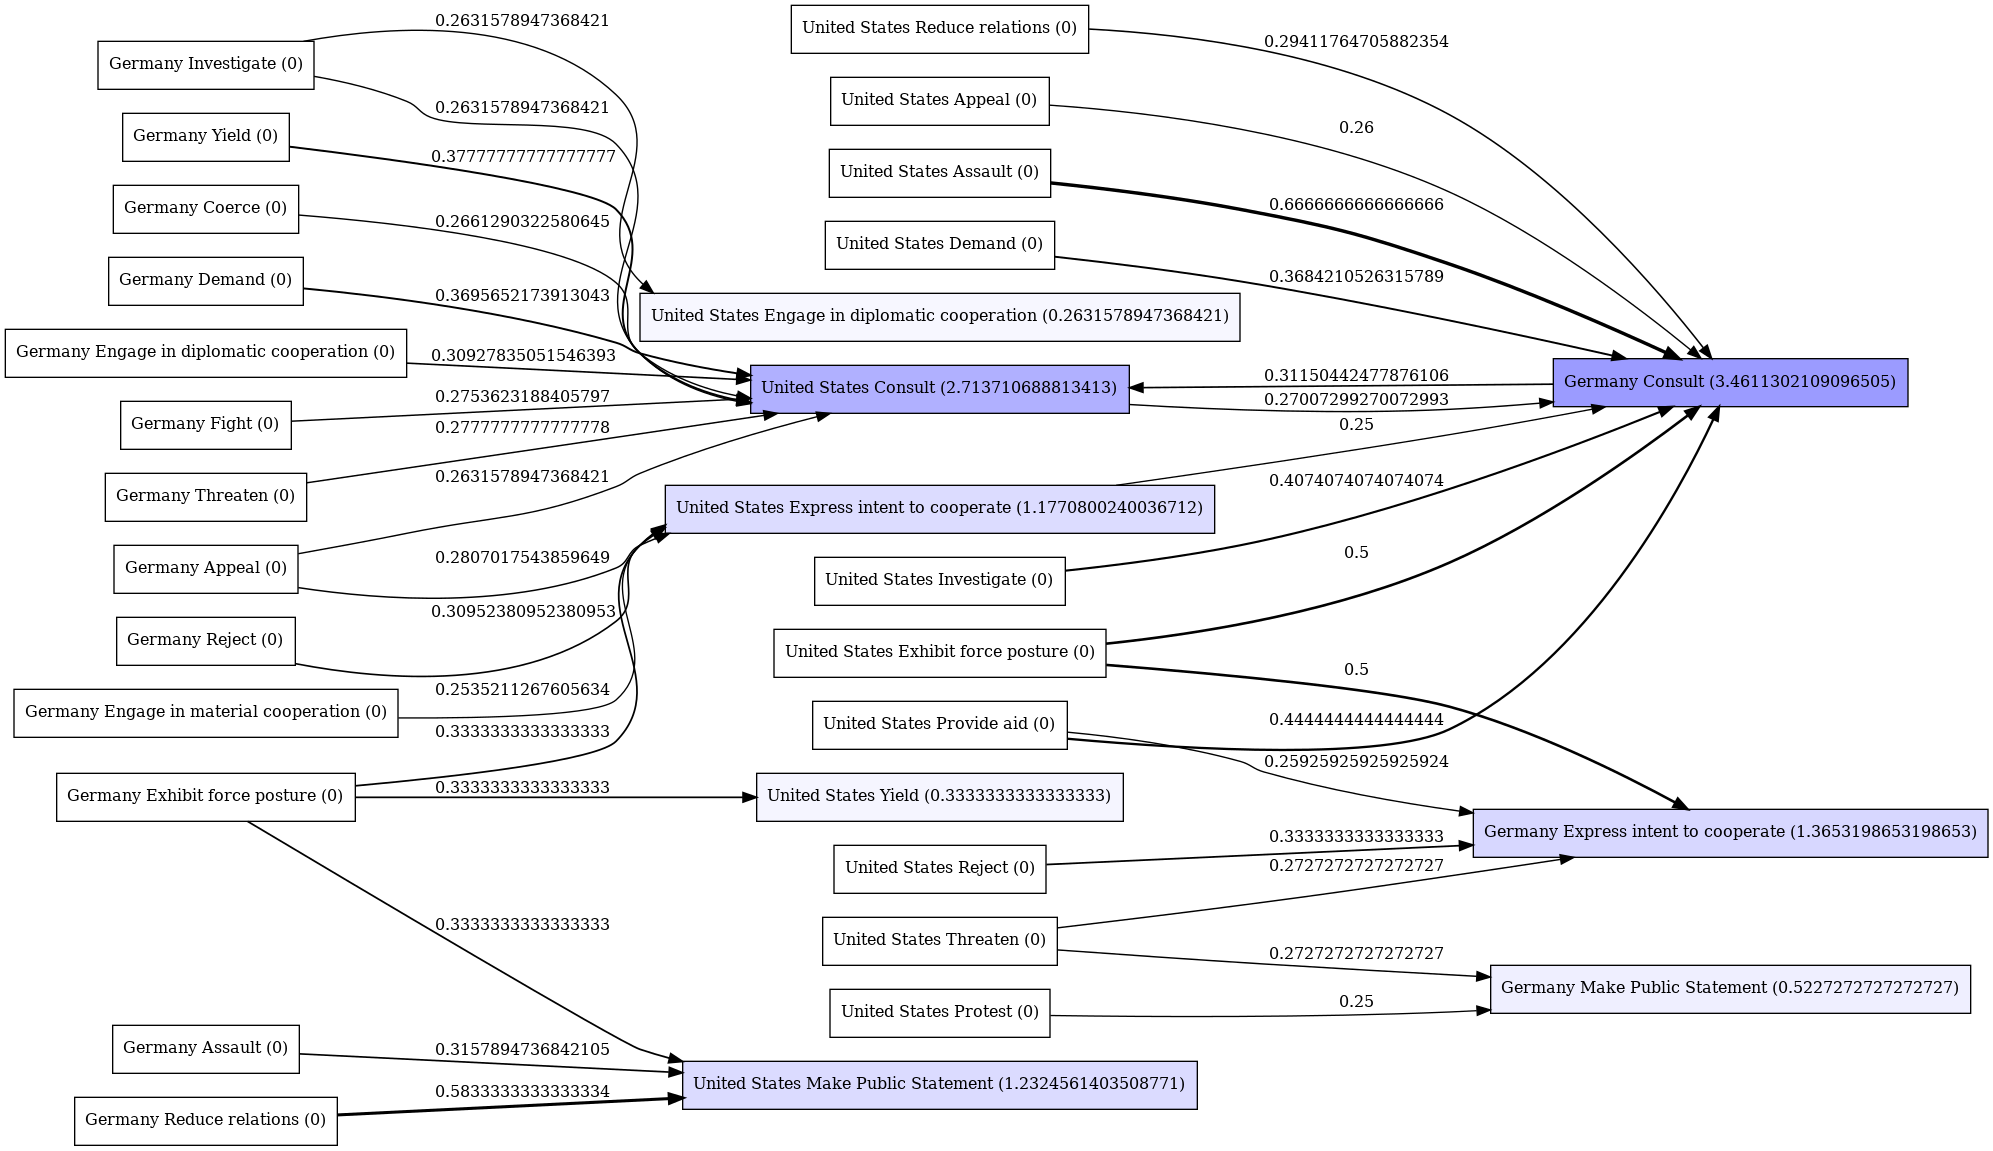

In [7]:
#example action reatction graph mergeing
#get aciton reaction graph in both directions
action_reaction_graph_USA_DEU = pm4pyExtension.algo.discovery.get_action_reaction_graph(interaction_event_log_USA_DEU, interaction_event_log_DEU_USA, daysFollow=10)
action_reaction_graph_DEU_USA = pm4pyExtension.algo.discovery.get_action_reaction_graph(interaction_event_log_DEU_USA, interaction_event_log_USA_DEU, daysFollow=10)

efgs_clean = []
for efg in [action_reaction_graph_USA_DEU, action_reaction_graph_DEU_USA]:
    nefg = pm4pyExtension.tools.normalize_dfg_to(efg, normalize_to="source")
    #nefg = pm4pyExtension.algo.reduction.minthreshold_dfg(efg, 0.2)
    efgs_clean.append(nefg)
    #pm4py.view_dfg(nefg, start_activities=None, end_activities=None, format='png')

efg_ar_merge = pm4pyExtension.algo.merging.merge_action_reaction_graphs (efgs_clean, ["United States","Germany"]) #carefull order matters here
#efg_ar_merge = pm4pyExtension.tools.normalize_dfg_to(efg_ar_merge, normalize_to="source")

#filter out the edges that are not significant
efg_ar_merge_thresh = pm4pyExtension.algo.reduction.minthreshold_dfg(efg_ar_merge, 0.25)
pm4py.view_dfg(efg_ar_merge_thresh, start_activities=None, end_activities=None, format='png')


In [8]:

#action_reaction_graph_USA_DEU_GBR maps how DEU acts on GBR after USA acts on DEU
action_reaction_graph_USA_DEU_GBR = pm4pyExtension.algo.discovery.get_action_reaction_graph(interaction_event_log_USA_DEU, interaction_event_log_DEU_GBR, daysFollow=10)
#action_reaction_graph_DEU_USA_GBR maps how GBR acts on USA after DEU acts on GBR
action_reaction_graph_DEU_GBR_USA = pm4pyExtension.algo.discovery.get_action_reaction_graph(interaction_event_log_DEU_GBR, interaction_event_log_GBR_USA, daysFollow=10)
#action_reaction_graph_GBR_USA maps how USA acts on DEU after GBR acts on USA
action_reaction_graph_GBR_USA_DEU = pm4pyExtension.algo.discovery.get_action_reaction_graph(interaction_event_log_GBR_USA, interaction_event_log_USA_DEU, daysFollow=10)

#multi Country chain

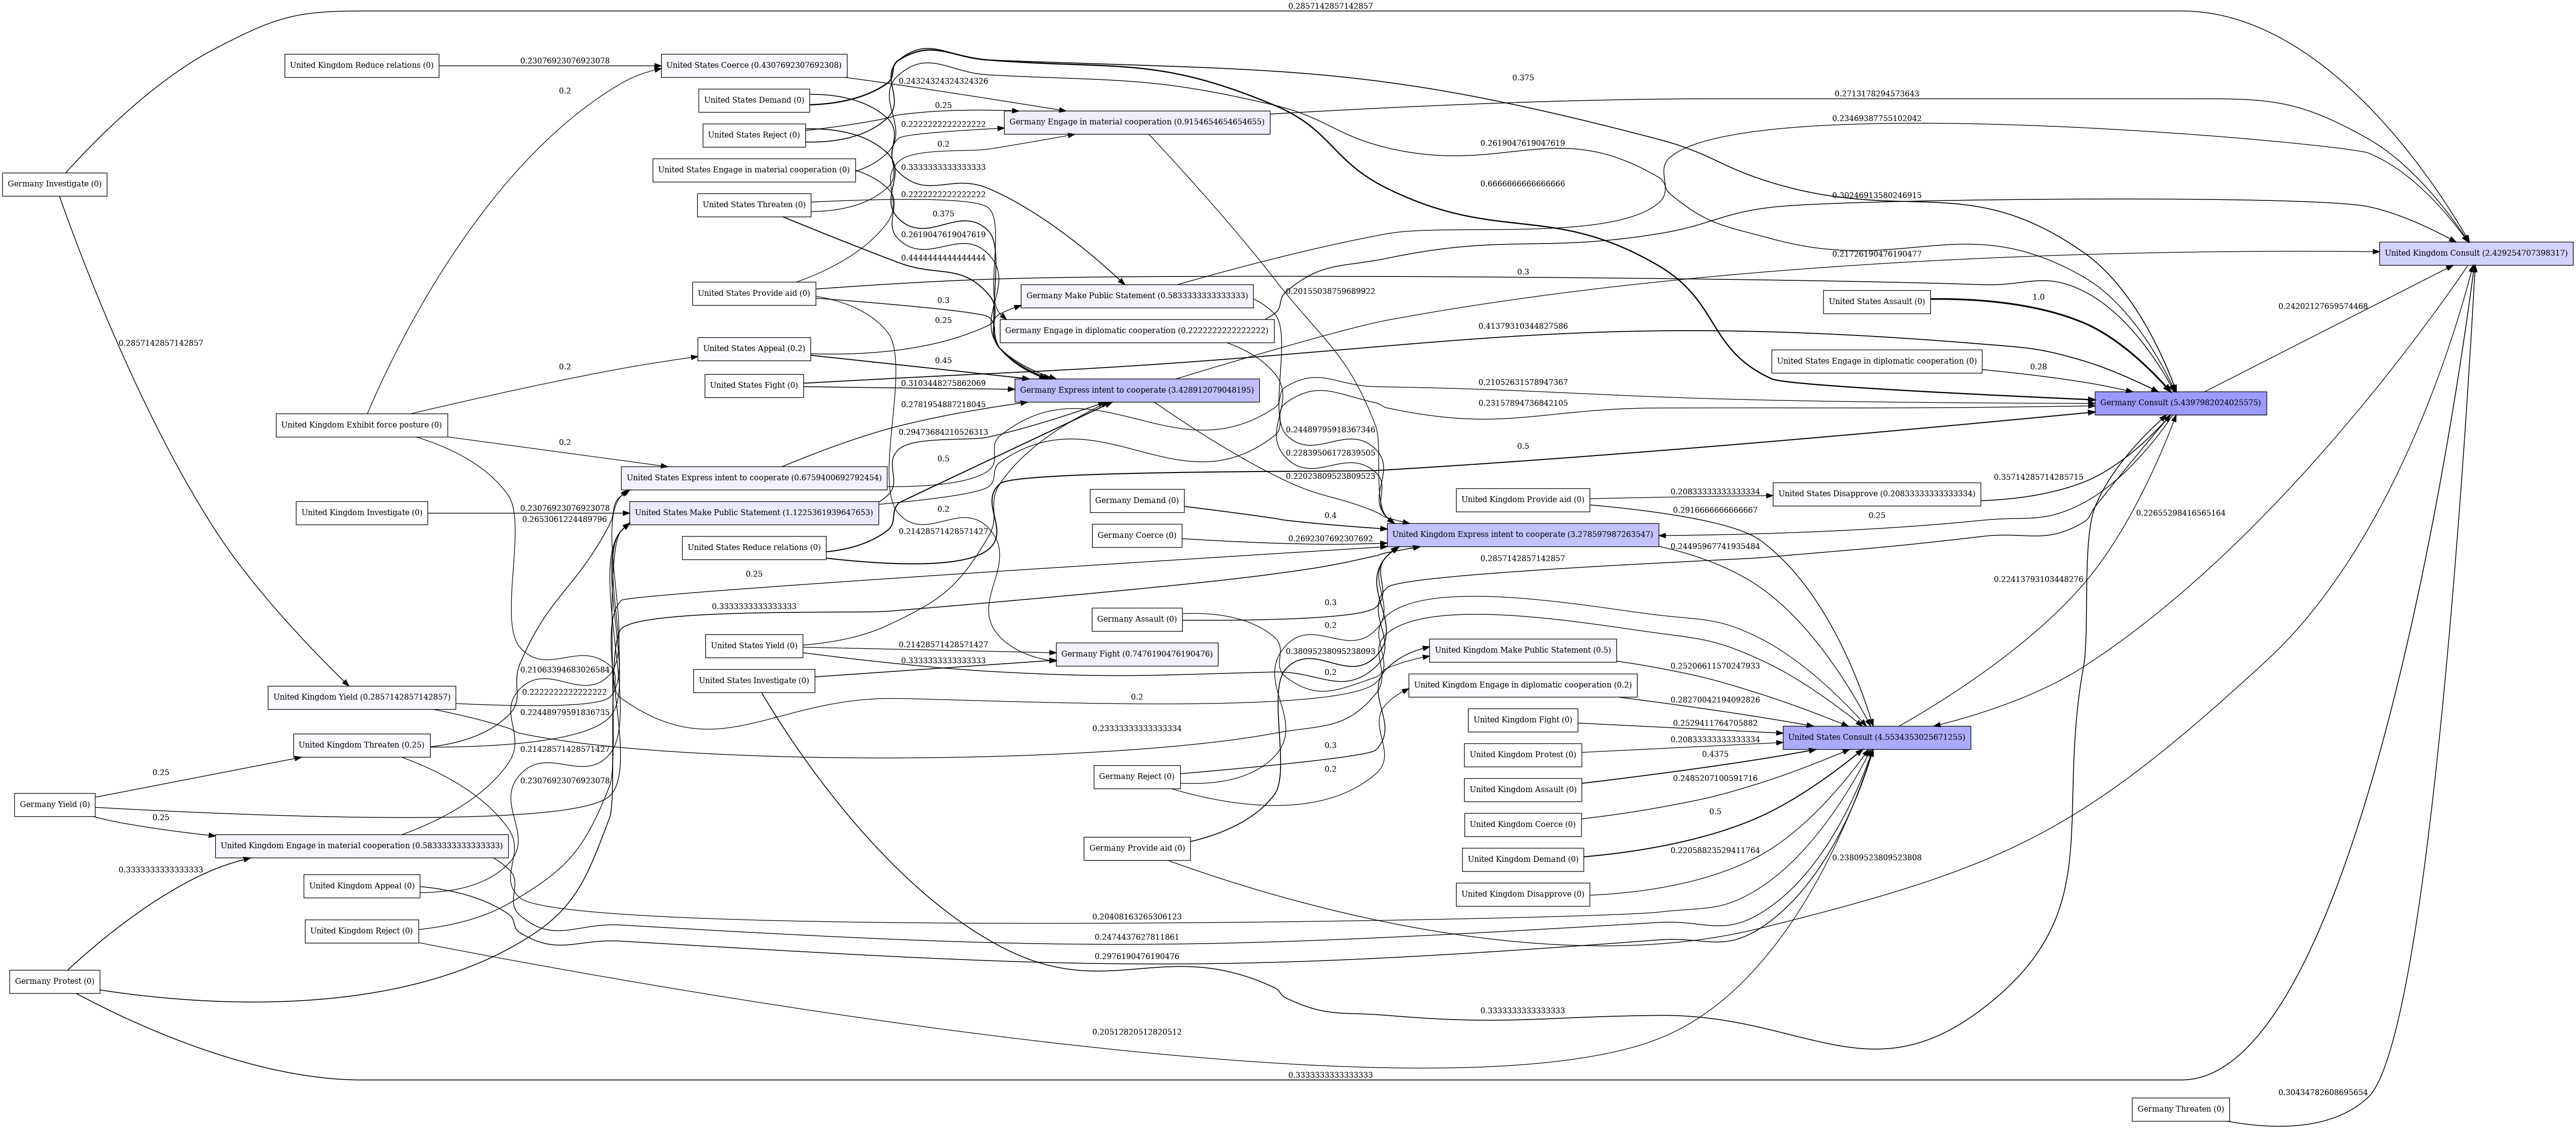

In [9]:
efgs_clean = []
for efg in [action_reaction_graph_USA_DEU_GBR, action_reaction_graph_DEU_GBR_USA, action_reaction_graph_GBR_USA_DEU]:
    nefg = pm4pyExtension.algo.normalize.source_normalize_dfg(efg)
    #nefg = pm4pyExtension.algo.reduction.minthreshold_dfg(efg, 0.2)
    efgs_clean.append(nefg)
    #pm4py.view_dfg(nefg, start_activities=None, end_activities=None, format='png')

efg_ar_merge = pm4pyExtension.algo.merging.merge_action_reaction_graphs (efgs_clean, ["United States","Germany", "United Kingdom"])
efg_ar_merge = pm4pyExtension.algo.reduction.minthreshold_dfg(efg_ar_merge, 0.2)
pm4py.view_dfg(efg_ar_merge, start_activities=None, end_activities=None, format='png')